In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_8844/3827359723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ds_version = "RTK"
annotations_file = "GT_RTK.csv"
# lmh crop
pred_file = "RTK_lmh-crop_trained_prediction-RTK_GT-20240809_130335.csv"
root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file
only_validation = True

In [3]:
pred = pd.DataFrame()

print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, pred_file))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_pred"}, inplace=True)

quality_pred = pred[pred.Level == "quality"][["image_id", "Prediction", "quality_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]
pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")


reading RTK_lmh-crop_trained_prediction-RTK_GT-20240809_130335.csv


In [4]:
annot = pd.read_csv(os.path.join(data_path, annotations_file))
annot["quality_float_true"] = annot["quality_true"].map({"good": 2, "regular": 3, "bad": 4})

In [5]:
df = pred.join(
    annot[["image_id", "type_true", "quality_true", "quality_float_true"]].set_index("image_id"), how="left")

In [6]:
df.groupby(["type_true", "quality_true"]).size()

type_true  quality_true
asphalt    bad              464
           good            1978
           regular          839
paved      bad              124
           regular          324
unpaved    bad              593
           regular          796
dtype: int64

In [7]:
df.shape

(5118, 9)

In [8]:
df_valid_type = df[df.is_in_validation_type == 1]
df_train_type = df[df.is_in_validation_type == 0]

df_valid_quality = df[df.is_in_validation_quality == 1]
df_train_quality = df[df.is_in_validation_quality == 0]

In [9]:
print(df_valid_type.shape)
print(df_train_type.shape)
print(df_valid_type.shape[0] + df_train_type.shape[0])
print(df_valid_quality.shape)
print(df_train_quality.shape)
print(df_valid_quality.shape[0] + df_train_quality.shape[0])


(1024, 9)
(4094, 9)
5118
(1024, 9)
(4094, 9)
5118


## Global measures

In [10]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

#### global measures for type

In [11]:
# all
gm = compute_measures_cat(df.type_true, df.type_pred)
gm_valid = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
gm_train = compute_measures_cat(df_train_type.type_true, df_train_type.type_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)

,all,validation,train
accuracy,1.0,1.0,1.0


#### global measures for quality

In [12]:
# all
gm = compute_measures_float(df.quality_float_true, df.quality_float_pred)
gm_valid = compute_measures_float(df_valid_quality.quality_float_true, df_valid_quality.quality_float_pred)
gm_train = compute_measures_float(df_train_quality.quality_float_true, df_train_quality.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(3)

,all,validation,train
accuracy,0.991,0.979,0.993
correlation,0.041,0.973,0.038
r_square,-722.442,0.945,-903.297
mse,428.989,0.033,536.280
mae,0.448,0.124,0.529
rmse,20.712,0.180,23.158


## Surface type

In [13]:
#plt.rcParams.update({'font.size': 14})

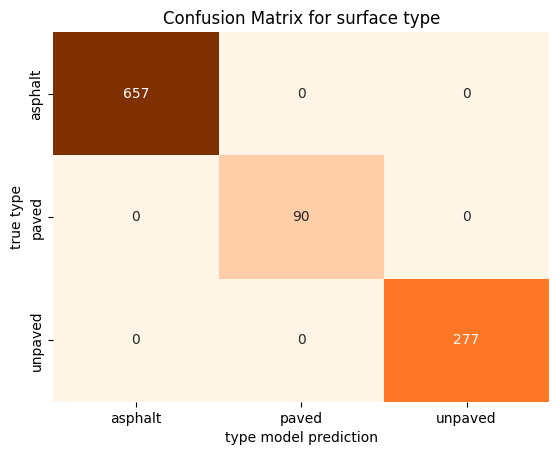

In [14]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

cm = confusion_matrix(df_valid_type.type_true, df_valid_type.type_pred, labels=["asphalt", "paved", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "paved", "unpaved"],
            yticklabels=["asphalt", "paved", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

## Measures for quality by surface type

In [15]:
gm_surface = pd.DataFrame()
for surface in df_valid_quality.type_true.unique():
    df_ = df_valid_quality[df_valid_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,paved,unpaved
accuracy,0.98,0.92,0.99
correlation,0.98,0.79,0.95
r_square,0.95,0.58,0.89
mse,0.03,0.08,0.03
mae,0.11,0.23,0.12
rmse,0.17,0.29,0.17


## compare float values

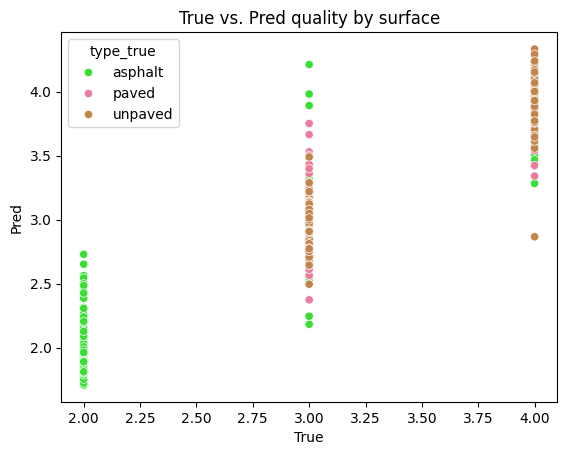

In [16]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df_valid_quality.type_true.unique()}

sns.scatterplot(data=df_valid_quality, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


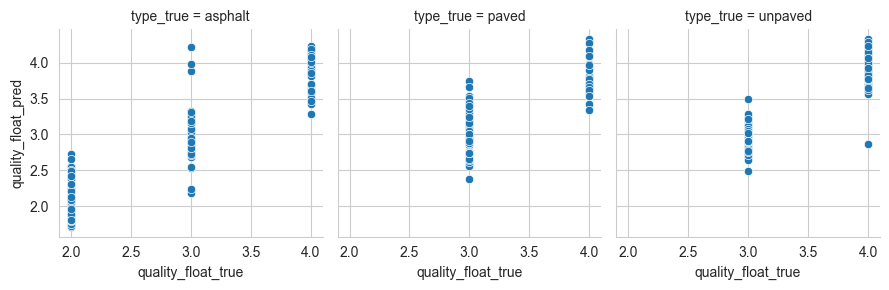

In [17]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [18]:
df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_8844/1573003093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred


**Overall**

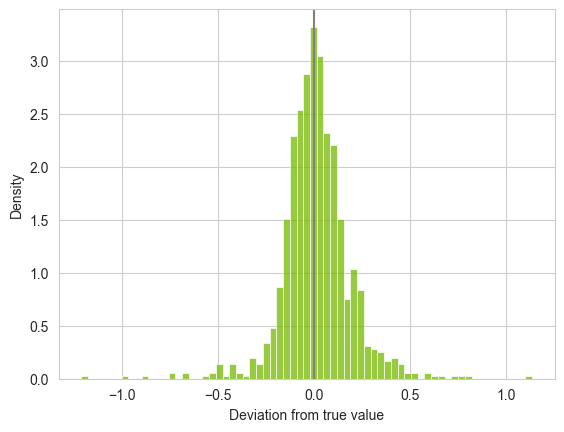

In [19]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [20]:
np.mean(df_valid_quality.deviation)

0.011129838880151496

In [21]:
np.std(df_valid_quality.deviation)


0.17993863820051342

In [22]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1022
True        2
Name: count, dtype: int64

In [23]:
120/len(df_valid_quality)

0.1171875

**by surface**

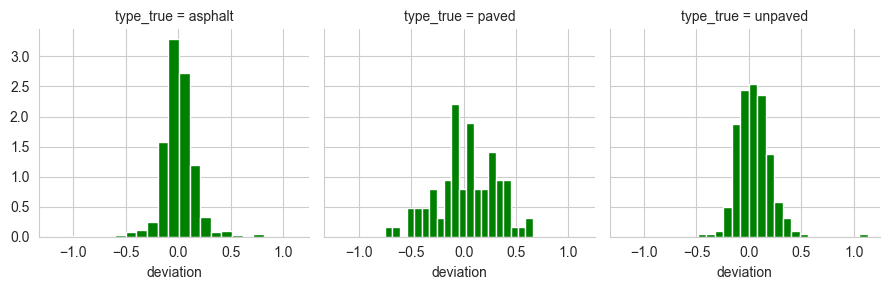

In [24]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

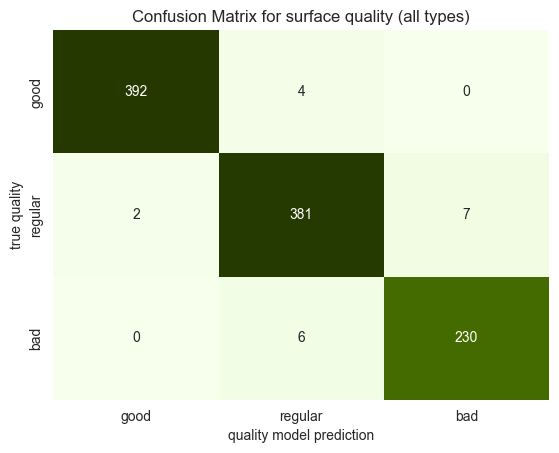

In [25]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_true, df_valid_quality.quality_pred, labels=["good", "regular", "bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["good", "regular", "bad"],
            yticklabels=["good", "regular", "bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

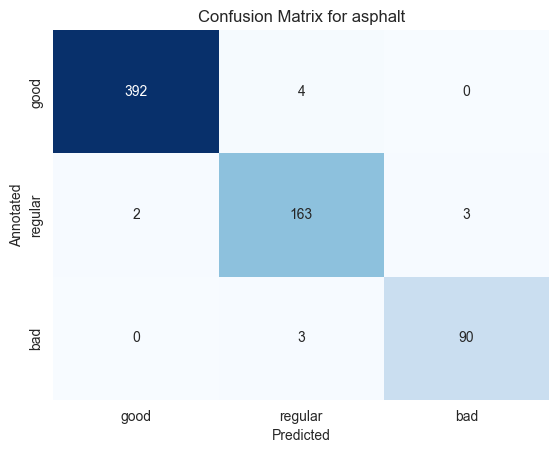

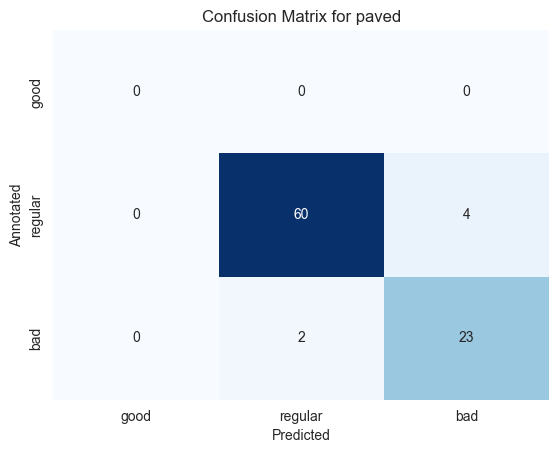

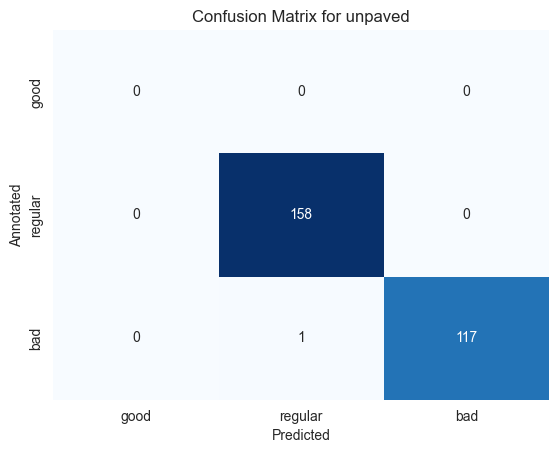

In [26]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_true, _df.quality_pred, labels=["good", "regular", "bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["good", "regular", "bad"],
                yticklabels=["good", "regular", "bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [27]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 657
Count (true): 657
Precision: 1.0
Recall: 1.0
------------------------
Class: paved
Count (pred): 90
Count (true): 90
Precision: 1.0
Recall: 1.0
------------------------
Class: unpaved
Count (pred): 277
Count (true): 277
Precision: 1.0
Recall: 1.0
------------------------
------------------------
------------------------
Average precision: 1.0
Average recall: 1.0
Average F1-Score: 1.0
Accuracy: 1.0
